# specimensテーブル統計データ

specimensテーブル(マウス標本)の統計データです。

マウスの性別, 年齢(日数), 体重(g),　系統データや、注入方式, 脳内の位置, 薬物情報についての情報を掲載します。


In [ ]:
# Pythonライブラリインストール
!python --version
!pip install python-dotenv

!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install plotly
!pip install -U kaleido
!pip install -U nbformat
!pip install scikit-learn
!pip install sqlalchemy


## 環境変数
supabase接続用URL,APIキーと、openai api接続用のAPIキーを設定します。
自身のopenaiアカウントからapi keyを取得してください。

https://platform.openai.com/account/api-keys

supabaseの情報は管理者にお尋ねください。

下記の例では、.envファイルに変数を書き込んで、JupiterNotebookで読み込む仕様で実装しております。

※.envファイルの作成が困難、.envファイルから値を読み込めない場合、
　os.getenv("◯◯")部分に変数値を直接書き込んでいただいても動作自体には問題ありません。

In [10]:
# 環境変数
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sqlalchemy import create_engine
from sqlalchemy import text
import urllib.parse

load_dotenv()

# supabase接続用変数
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_pass = os.getenv("DB_PASS")

# Connect to the database
connection_config = {
    'user': db_user,
    'password': urllib.parse.quote_plus(db_pass),
    'host': db_host,
    'port': db_port, 
    'database': db_name
}
engine = create_engine('postgresql://{user}:{password}@{host}:{port}/{database}'.format(**connection_config))
sql = 'SELECT * FROM specimens ORDER BY id ASC;'

with engine.begin() as conn:
    query = text(sql)
    df_original = pd.read_sql_query(query, conn)

print('環境変数読み込み完了')

環境変数読み込み完了


## 処理関数

- ヒストグラム
- 円グラフ

In [11]:

%matplotlib inline

def piechart(label:str, df, title:str):
  # Counting the occurrences of each category
  category_counts = df[label].value_counts()
  # Plotting the pie chart
  plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%',startangle=90)
  plt.title(title+'(n='+str(len(df))+')')
  plt.axis('equal')
  plt.show()


def histgram(label:str, df, xlabel:str, ylabel:str, title:str, x_max):
  # Calculate average and other statistics
  mean = np.mean(df[label])
  median = np.median(df[label])
  std_dev = np.std(df[label])

  # Plot the histogram
  n, bins, patches = plt.hist(df[label], bins=len(set(df[label])), alpha=0.75)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title+'(n='+str(len(df))+')')

  y_max = max(n)
  #x_max = max(df[label])

  # Add statistics to the plot
  plt.axvline(mean, color='red', linestyle='dashed', linewidth=2)
  plt.text(mean+1, (plt.ylim()[1]-y_max/4), f'Mean: {mean}', color='red')

  plt.axvline(median, color='blue', linestyle='solid', linewidth=2)
  plt.text(median+1, (plt.ylim()[1]-y_max/3), f'Median: {median}', color='blue')

  plt.axhline(std_dev, color='green', linestyle='dotted', linewidth=2)
  plt.text(plt.xlim()[0], std_dev, f'Std Dev: {std_dev:.2f}', color='green')

  # Show the plot
  plt.xlim(min(df[label]),x_max)
  plt.show()



# 処理結果

## 性別

['M = male(1482)', 'F = female(927)']


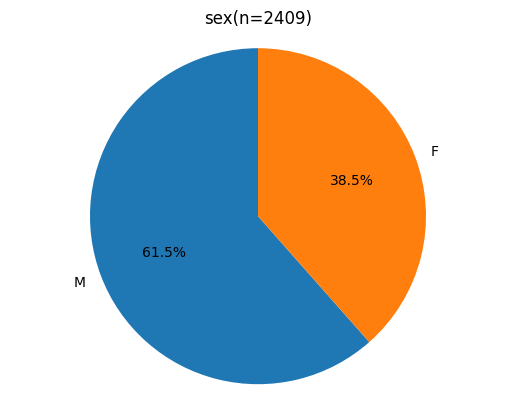

In [12]:
df = df_original.copy()
df_male = df[df['sex'] == "M"]
df_female = df[df['sex'] == "F"]

labels = ['M = male('+str(len(df_male))+')', 'F = female('+str(len(df_female))+')']
print(labels)

piechart('sex', df, 'sex')

## 年齢(出生後経過日数), 体重(g)

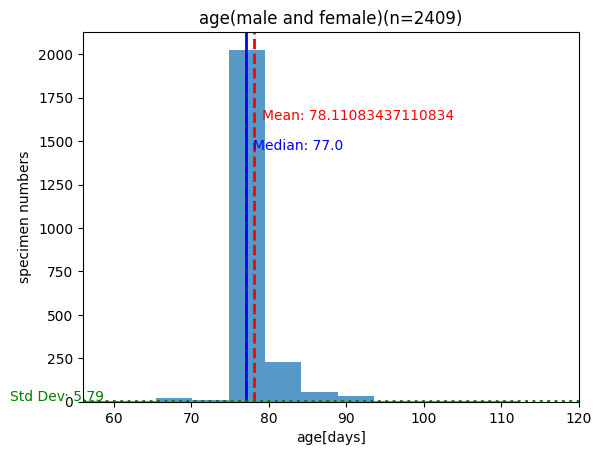

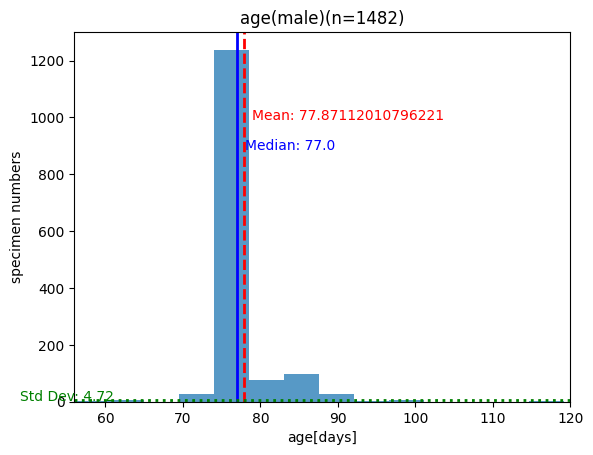

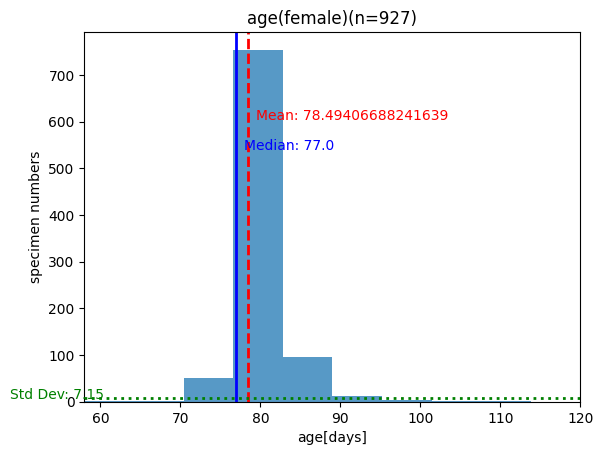

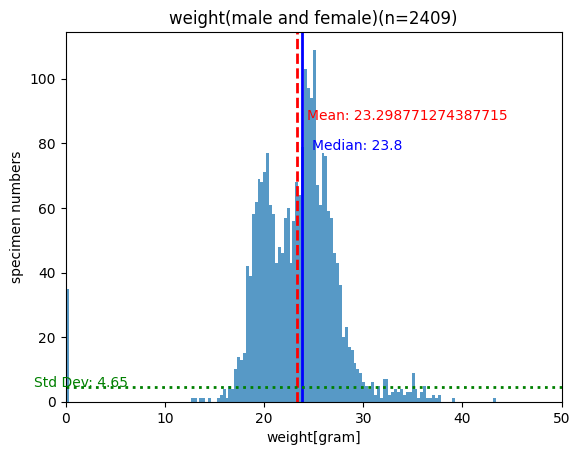

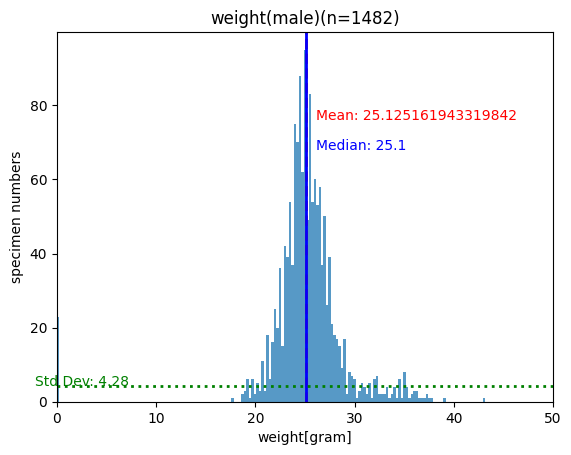

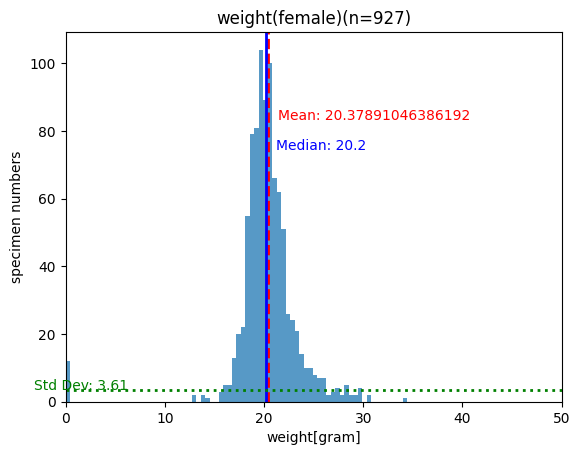

In [13]:
histgram('age', df, 'age[days]', 'specimen numbers', 'age(male and female)',120)
histgram('age', df_male, 'age[days]', 'specimen numbers', 'age(male)',120)
histgram('age', df_female, 'age[days]', 'specimen numbers', 'age(female)',120)

histgram('weight', df, 'weight[gram]', 'specimen numbers', 'weight(male and female)',50)
histgram('weight', df_male, 'weight[gram]', 'specimen numbers', 'weight(male)',50)
histgram('weight', df_female, 'weight[gram]', 'specimen numbers', 'weight(female)',50)

## マウス系統, 注入方式, 薬物情報

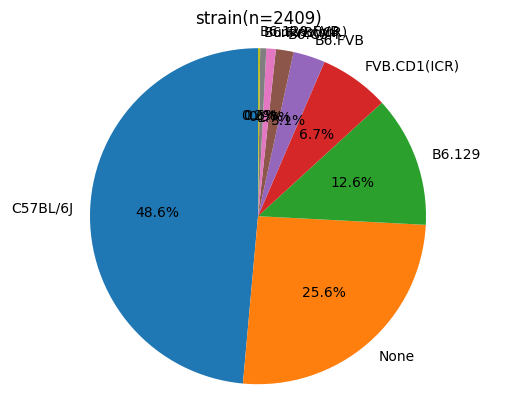

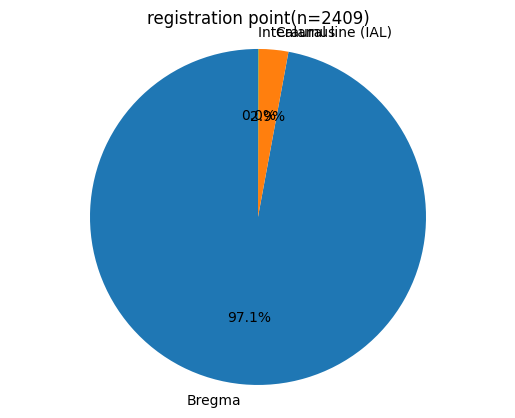

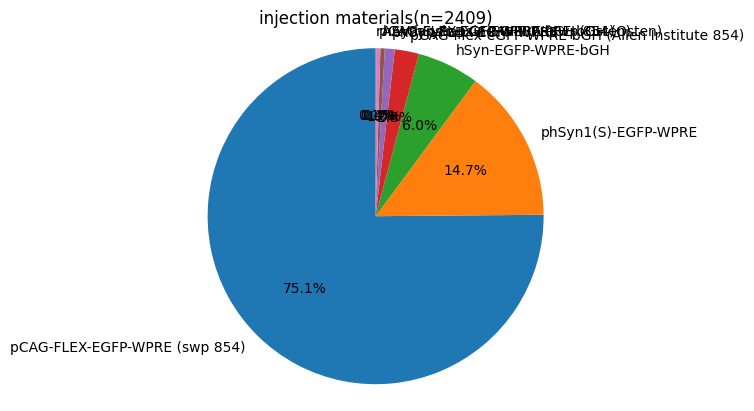

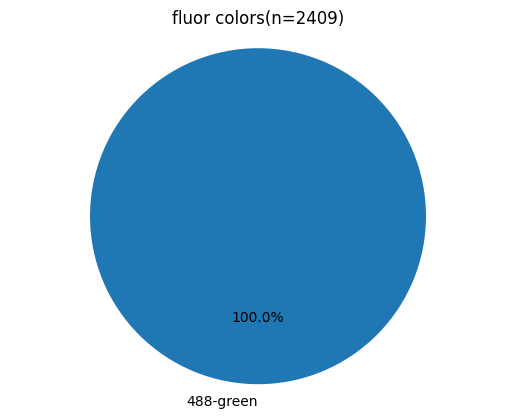

In [14]:
df = df_original.copy()

piechart('strain', df, 'strain')
piechart('registration-point', df, 'registration point')
piechart('injection-materials', df, 'injection materials')
piechart('fluor-colors', df, 'fluor colors')



## 注入後経過日数

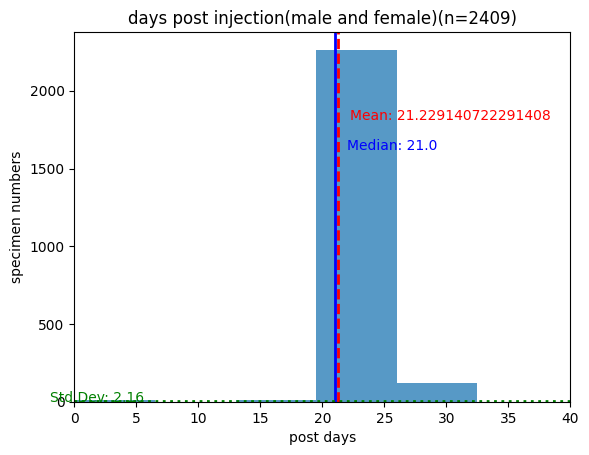

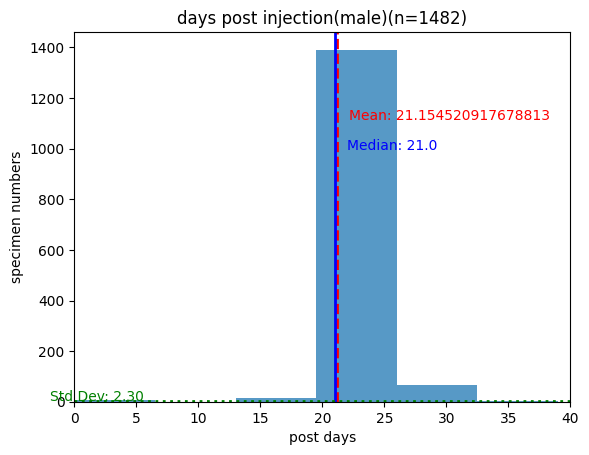

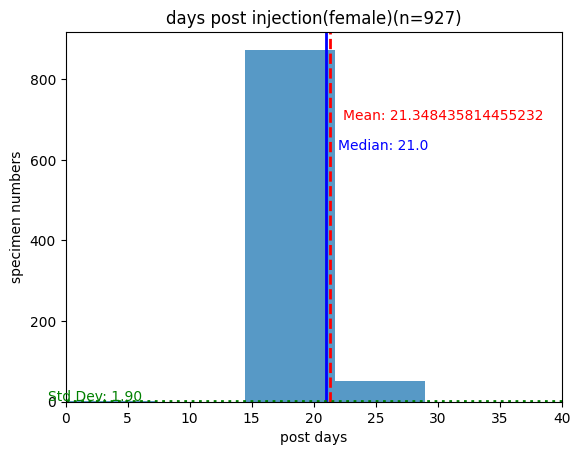

In [15]:
df = df_original.copy()
df_male = df[df['sex'] == "M"]
df_female = df[df['sex'] == "F"]

histgram('days-post-injection', df, 'post days', 'specimen numbers', 'days post injection(male and female)',40)
histgram('days-post-injection', df_male, 'post days', 'specimen numbers', 'days post injection(male)',40)
histgram('days-post-injection', df_female, 'post days', 'specimen numbers', 'days post injection(female)',40)

## Bregma基準軸における注入箇所

In [16]:
import plotly.express as px

df = df_original.copy()
df = df[df['registration-point'] == 'Bregma']
# 外れ値
df = df[df['coordinates-ml'] > -2]
df = df[df['coordinates-dv'] < 50]

# Create a 3D scatter plot using Plotly Express
fig = px.scatter_3d(df, x='coordinates-ml', y='coordinates-ap', z='coordinates-dv',
                    title='3D Bregma Coordinate Graph(n='+str(len(df))+')',
                    labels={'coordinates-ml': 'Medial-lateral', 'coordinates-ap': 'Anterior-posterior', 'coordinates-dv': 'Dorsal-ventral'},
                    width=1000, height=800,
                    symbol_sequence=['circle'], size_max=10)

# Invert y-axis to keep proper bregma coordinate orientation
fig.update_layout(scene=dict(yaxis=dict(autorange="reversed")))

# Show the plot
fig.show()